# Dependencies

In [0]:
# remove this line to get outputs
%%capture
##########
!pip install pyworld
!pip install soundfile
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install plotly
!apt-get install libsndfile-dev -y


## Drive integration

In [0]:
##https://colab.research.google.com/notebook#fileId=1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q&scrollTo=XoDG4oKpoeyS
# remove this line to get outputs
%%capture
##########
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!fusermount -u drive
!rmdir drive
!mkdir -p drive

!google-drive-ocamlfuse drive

fusermount: failed to unmount /content/drive: No such file or directory
rmdir: failed to remove 'drive': No such file or directory


In [1]:
import os
print('Files in Drive:')
basePath = 'drive/Colab_Notebooks/TigerCostume'
escapedBasePath = str.replace(basePath, ' ', '\ ')
print(os.listdir(basePath))

Files in Drive:
['IEEE_days.ipynb', 'papers', 'train_samples', 'sounds', 'citations', 'images', 'train_data', 'tiger_costume.ipynb', 'python', 'local_modules', 'clean_tiger_costume.ipynb', 'Dataset Analysis.ipynb', 'local_modules.ipynb', 'RUN_MODELS.ipynb']


## Functions

In [0]:
import sys
sys.path.append(basePath+'/local_modules')
# Now we can import our new module and call our function.
from display import *
from dataset import *
from cepstrum_dtw import *
import os
import pyworld as pw
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

import IPython
from IPython.core.display import HTML, clear_output

import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

from __future__ import absolute_import, division, print_function
from scipy.fftpack import dct
from scipy import signal

# Dataset Configuration

In [5]:




# Configuration parameters 

N_S_TS = 20 # Number of source trainsamples
N_T_TS = 20 # Number of source trainsamples

fs = 16000

dec_factor = 1
fs_ds = int(fs/dec_factor);

N_t = 0.020
w_ratio = 4;
M_t = N_t/w_ratio;

f0_floor = 71.0
f0_ceil = 800.0
frame_period = M_t*1000;
w_ratio_samples = int(frame_period*(fs_ds/1000))


q1 = -0.15
threshold = 0.85

fft_size = pw.get_cheaptrick_fft_size(fs_ds,f0_floor)

f_stop = 4000
sp_coefs = int(round(f_stop*fft_size/fs_ds*2))
feature_size = int(fft_size/2)+sp_coefs+2


print("N_t (Long ventana): %.3f s" % (N_t))
print("M_t (Avance ventana): %.3f s" % (M_t))

print("Numero de ventanas(f0) por ventana (N): %d " % (w_ratio))
print("Periodo de ventana para f0: %.3f s" % (frame_period/1000))
print("Tamaño FFT: %.3f s" % (fft_size))
print("SP coefs: %.3f" % (sp_coefs))

print("Factor de diezmado: %d" % (dec_factor))
print("Fs: %.2f Hz to %.2f Hz" % (fs, fs_ds))

N_t (Long ventana): 0.020 s
M_t (Avance ventana): 0.005 s
Numero de ventanas(f0) por ventana (N): 4 
Periodo de ventana para f0: 0.005 s
Tamaño FFT: 1024.000 s
SP coefs: 512.000
Factor de diezmado: 1
Fs: 16000.00 Hz to 16000.00 Hz


# Analysis

In [16]:
#@title Training samples
dataset_name = "unos" #@param ["unos", "otorrinolaringologo"]
from scipy import signal, misc

working_directory = basePath+'/train_data/' + dataset_name

print(os.listdir(working_directory))

if dataset_name == 'unos':
  file_javi = working_directory + '/wav/javi_uno.wav'
  file_alberto = working_directory + '/wav/alberto_uno.wav'
  file_raquel = working_directory + '/wav/raquel_uno.wav'

  x_javi,fs_wav = from_wav(file_javi)
  if not fs ==fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_javi = signal.decimate(x_javi, dec_factor, ftype='fir');
  ts_javi = train_samples(x_javi,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)

  x_alb,fs_wav = from_wav(file_alberto)
  if not fs == fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_alb = signal.decimate(x_alb, dec_factor, ftype='fir');
  ts_alb = train_samples(x_alb,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)

#   x_raq,fs_wav = from_wav(file_raquel)
#   if not fs == fs_wav:
#     print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
#   if dec_factor > 1:
#     x_raq = signal.decimate(x_raq, dec_factor, ftype='fir');
#   ts_raq = train_samples(x_raq,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)

elif dataset_name == 'otorrinolaringologo':
  
  file_javi = basePath + '/train_samples/javi_oto_16.wav'
  file_alberto = basePath + '/train_samples/alb_oto_16.wav'

  x_javi,fs_wav = from_wav(file_javi)
  if not fs ==fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_javi = signal.decimate(x_javi, dec_factor, ftype='fir');
  ts_javi = dataset.train_samples(x_javi,fs_ds,ns = 0.5,t1=250, t2=10, nth1=50, nth2=20)

  x_alb,fs_wav = from_wav(file_alberto)
  if not fs == fs_wav:
    print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
  if dec_factor > 1:
    x_alb = signal.decimate(x_alb, dec_factor, ftype='fir');
  ts_alb = dataset.train_samples(x_alb,fs_ds,ns = 0.5,t1=250, t2=10, nth1=50, nth2=20)

#   x_raq,fs_wav = from_wav(file_raquel)
#   if not fs == fs_wav:
#     print('WARNING: Configuration fs mismatch: %d != %d' % (fs_wav, fs))
#   if dec_factor > 1:
#     x_raq = signal.decimate(x_raq, dec_factor, ftype='fir');
#   ts_raq = train_samples(x_raq,fs_ds,ns=1,t1=400, t2=10, nth1=50, nth2=20)
  
ts_s = ts_javi
print(ts_s.shape)
ts_t = ts_alb
print(ts_t.shape)

del x_javi
del x_alb
del ts_javi
del ts_alb

['wav', 'features']
(20, 14880)
(20, 12160)


Processing batch 10...
Processing target batch 4...

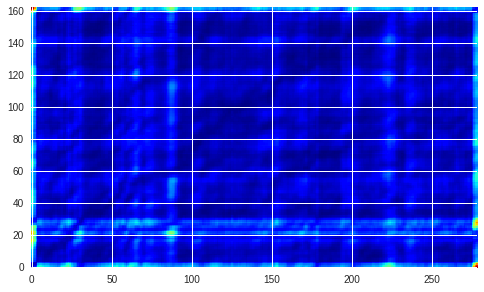

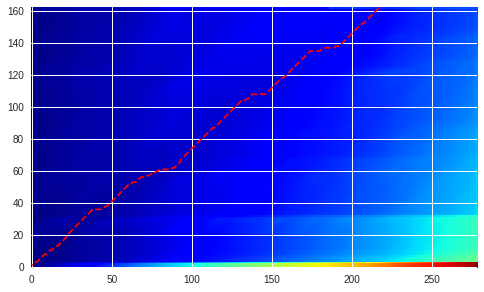

(880, 2052)


In [39]:


#@title Alignment { form-width: "20%" }
DRY_RUN = True #@param {type:"boolean"}
batches_s = [10] #@param ["range(N_S_TS)", "range(0,5)", "[2]"] {type:"raw", allow-input: true}
batches_t = [4] #@param ["range(N_T_TS)", "range(0,4)", "[3]"] {type:"raw", allow-input: true}
# DATASET ACQUISISTION AND ALIGNMENT


configure_plotly_browser_state()
init_notebook_mode(connected=False)


# batches_s = range(N_S_TS)
# batches_t = range(N_T_TS)    

# batches_s = [2]
# batches_t = [3]

ST = np.empty((0, 2*(fft_size+3)))

for ts_s_i in batches_s:
  s_data = np.empty((0, feature_size))
  t_data = np.empty((0, feature_size))
  
  #Low Eneregy Silence filtering
  tmp_s = silence_filter(ts_s[ts_s_i,:], frame_period, fs_ds)[0]
  
  # F0 extraction of filtered signal 
  f0_s, tp_s = pw.harvest(tmp_s, fs_ds,f0_floor, f0_ceil, frame_period)
  
  
  if np.count_nonzero(f0_s) > 0: # Found F0
    
#     print("Processing batch %d..." % (ts_s_i))
    
    f0_s_se = f0_start_end(f0_s)
    
    sp_s = pw.cheaptrick(tmp_s, f0_s, tp_s, fs_ds, q1, f0_floor, fft_size)
    ap_s = pw.d4c(tmp_s, f0_s, tp_s, fs_ds, threshold, fft_size)

    # Get only features where f0 was found
    f0_s = f0_s[f0_s_se[0]:f0_s_se[1]]
    sp_s = sp_s[f0_s_se[0]:f0_s_se[1],0:sp_coefs]
    ap_s = ap_s[f0_s_se[0]:f0_s_se[1],:]
    
    feature_s = np.concatenate((f0_s.reshape(len(f0_s),1), sp_s, ap_s),1)

    # Filter signal in time domain, only temporal positions where f0 was found
    tmp_s = tmp_s[int(f0_s_se[0]*w_ratio_samples):int(f0_s_se[1]*w_ratio_samples)]

    # Calculate cepstrum of filtered signal
    tmp_s_cep = get_mel_cepstrum(tmp_s, fs_ds, N_t, M_t, hamming=True, NFFT=512, nMelFilt = 24, nCeps = 13, substractMean = True)

    for ts_t_i in batches_t:
      clear_output()
      print("Processing batch %d..." % (ts_s_i))
      sys.stdout.write('\r')
      sys.stdout.write("Processing target batch %d..." % (ts_t_i))
      sys.stdout.flush()
      
      # Low Eneregy Silence filtering
      tmp_t = silence_filter(ts_t[ts_t_i,:], frame_period, fs_ds)[0]

      # F0 extraction of target filtered signal 
      f0_t, tp_t = pw.harvest(tmp_t, fs_ds,f0_floor, f0_ceil, frame_period)

      if np.count_nonzero(f0_t) > 0:        
          
          f0_t_se = f0_start_end(f0_t)
          
          sp_t = pw.cheaptrick(tmp_t, f0_t, tp_t, fs_ds, q1, f0_floor, fft_size)
          ap_t = pw.d4c(tmp_t, f0_t, tp_t, fs_ds, threshold, fft_size)
          f0_t = f0_t[f0_t_se[0]:f0_t_se[1]]
          sp_t = sp_t[f0_t_se[0]:f0_t_se[1],0:sp_coefs]
          ap_t = ap_t[f0_t_se[0]:f0_t_se[1],:]

          feature_t = np.concatenate((f0_t.reshape(len(f0_t),1), sp_t, ap_t),1)

          tmp_t = tmp_t[int(f0_t_se[0]*w_ratio_samples):int(f0_t_se[1]*w_ratio_samples)]

          tmp_t_cep = get_mel_cepstrum(tmp_t, fs_ds, N_t, M_t, hamming=True, NFFT=512, nMelFilt = 24, nCeps = 13, substractMean = True)
          tmp_s_cep_d = matx_derivatives(tmp_s_cep, Nderivatives=2)
          tmp_t_cep_d = matx_derivatives(tmp_t_cep, Nderivatives=2)
                     
          # Alignment          
          D = elementwyse_l2(tmp_s_cep_d, tmp_t_cep_d)
          C = genate_Cmtx(D)
          
          row_add_cost = (C.shape[1]-1)/np.arange(int(2/3*C.shape[1]),C.shape[1])
          C[-1,int(2/3*C.shape[1]):] = C[-1, int(2/3*C.shape[1]):]*row_add_cost
          
          start1 = [int(2/3*C.shape[0]) + np.argmin(C[int(2/3*C.shape[0]):,-1]) , C.shape[1] - 1]
          start2 = [C.shape[0] - 1, int(2/3*C.shape[1])+np.argmin(C[-1, int(2/3*C.shape[1]):])]
          if C[start1[0],start1[1]] <= C[start2[0],start2[1]]:
            start = start1
          else:
            start = start2
      
          C[-1,int(2/3*C.shape[1]):] = C[-1, int(2/3*C.shape[1]):]#/row_add_cost
          posV, posH = dtw_backtracking(C, start)
          

          plt.figure()
          plt.imshow(D, cmap='jet')
          plt.gca().invert_yaxis()
          plt.show()
          plt.figure()
          plt.imshow(C,  cmap='jet')
          plt.plot(posH, posV, 'r--')
          plt.gca().invert_yaxis()
          plt.show()
          
          # Follow DTW track
          for idx_track in range(len(posV)-1,-1,-1):
            window_stack_s = feature_s[posV[idx_track]:int(posV[idx_track]+w_ratio),:]
            window_stack_t = feature_t[posH[idx_track]:int(posH[idx_track]+w_ratio),:]
            if (window_stack_s.shape == window_stack_t.shape):
              s_data = np.append(s_data, window_stack_s, axis=0)
              t_data = np.append(t_data, window_stack_t, axis=0)
      
      else :
        print("Target batch %d discarded because no f0 detected" % (ts_s_t))    
  else:
    print("Batch %d discarded because no f0 detected" % (ts_s_i))
    
    
  st_data = np.concatenate([s_data,t_data], axis=1) 
  print(st_data.shape)
    
  if DRY_RUN == False:
    print("\nSaving data...")    
    np.save(basePath+"/train_data/ST_"+dataset_name+"_"+str(ts_s_i)+".npy",st_data)

### Debug

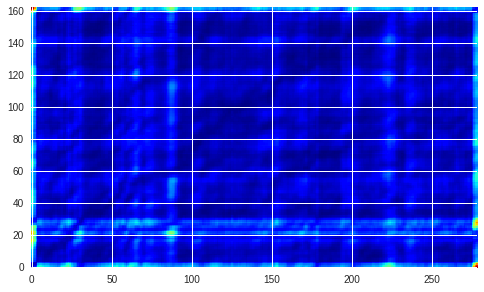

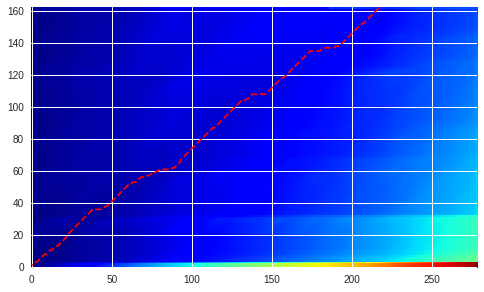

In [43]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)


plt.figure()
plt.imshow(D, cmap='jet')
plt.gca().invert_yaxis()
plt.show()
plt.figure()
plt.imshow(C,  cmap='jet')
plt.plot(posH, posV, 'r--')
plt.gca().invert_yaxis()
plt.show()

#### BEGIN SOURCE SIGNAL
layout = dict(title = 'SOURCE',
          xaxis = dict(title = 't',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace = go.Scatter(
   x = np.array(range(len(tmp_s)))/fs_ds,
#   x = tp_s,
  y = tmp_s,
  mode = 'lines',
  name = 'source'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)
#### END SOURCE SIGNAL

#### BEGIN TARGET SIGNAL
layout = dict(title = 'TARGET',
          xaxis = dict(title = 't',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace = go.Scatter(
   x = np.array(range(len(tmp_t)))/fs_ds,
#     x = tp_s,
  y = tmp_t,
  mode = 'lines',
  name = 'source'
)
fig = dict(data=[trace], layout=layout)
iplot(fig)
#### END SOURCE SIGNAL

#### BEGIN F0
layout = dict(title = 'F0',
          xaxis = dict(title = 't',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace1 = go.Scatter(
   x = np.array(range(len(f0_s))),
#     x = tp_s,
  y = f0_s,
  mode = 'lines',
  name = 'source'
)

trace2 = go.Scatter(
 x = np.array(range(len(f0_t))),
#      x = tp_t,
  y = f0_t,
  mode = 'lines',
  name = 'target'
)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
#### END F0

#### BEGIN F0 ALIGNMENT
layout = dict(title = 'F0 ALIGNMENT',
          xaxis = dict(title = '',
                      rangeslider=dict()),
          yaxis = dict(title = 'w'),
   )

trace1 = go.Scatter(
    x = np.array(range(len(s_data))),
#     x = tp_s,
    y = s_data[:,0],
    mode = 'lines',
    name = 'S'
)
trace2 = go.Scatter(
    x = np.array(range(len(t_data))),
#     x = tp_t,
    y = t_data[:,0],
    mode = 'lines',
    name = 'T'
)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
#### END F0 ALIGNMENT

f0_idx = 90
sp_idx = np.arange(1,int(fft_size/2)+2)
ap_idx = np.arange(int(fft_size/2)+2,s_data.shape[1])
f_range = np.linspace(0,int(fs_ds/2),len(s_data[f0_idx,sp_idx]))


#### BEGIN SP MEAN
layout = dict(title = 'SP MEAN)',
          xaxis = dict(title = 'f',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace1 = go.Scatter(
   x = f_range,
#     x = tp_s,
  y = np.mean(s_data[:,sp_idx],axis=0),
  mode = 'lines',
  name = 'source'
)
trace2 = go.Scatter(
   x = f_range,
#     x = tp_s,
  y = np.mean(t_data[:,sp_idx],axis=0),
  mode = 'lines',
  name = 'target'
)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
#### END SP MEAN

#### BEGIN SP ALIGNMENT
layout = dict(title = 'SP ('+str(f0_idx)+')',
          xaxis = dict(title = 'f',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace1 = go.Scatter(
   x = f_range,
#     x = tp_s,
  y = s_data[f0_idx,sp_idx],
  mode = 'lines',
  name = 'source'
)
trace2 = go.Scatter(
   x = f_range,
#     x = tp_s,
  y = t_data[f0_idx,sp_idx],
  mode = 'lines',
  name = 'target'
)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
#### END SP ALIGNMENT

#### BEGIN AP ALIGNMENT
layout = dict(title = 'AP ('+str(f0_idx)+')',
          xaxis = dict(title = 'f',
                      rangeslider=dict()),
          yaxis = dict(title = 'a'),
   )

trace1 = go.Scatter(
   x = f_range,
#     x = tp_s,
  y = s_data[f0_idx,ap_idx],
  mode = 'lines',
  name = 'source'
)
trace2 = go.Scatter(
   x = f_range, #np.array(range(len(t_data[f0_idx,ap_idx]))),
#     x = tp_s,
  y = t_data[f0_idx,ap_idx],
  mode = 'lines',
  name = 'target'
)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)
#### BEGIN AP ALIGNMENT

f0_idx = f0_idx + 1

## Post-Process

In [0]:
!ls "drive/Colab Notebooks/TigerCostume/train_data"

In [0]:
import pandas as pd

#@title Alignment { form-width: "20%" }
DRY_RUN = True #@param {type:"boolean"}
batches = range(N_S_TS) #@param ["range(N_S_TS)", "range(0,5)", "[2]"] {type:"raw", allow-input: true}

ST = np.empty((0, 2*feature_size))
for ts_i in batches:
  clear_output()
  print("Dataset drop duplicates")
  sys.stdout.write('\r')
  sys.stdout.write("Loading batch %d..." % (ts_i))
  sys.stdout.flush()
  st_tmp = np.load(basePath+"/train_data/ST_"+dataset_name+"_"+str(ts_i)+".npy")
  sys.stdout.write('\r')
  sys.stdout.write("Loading batch %d [DONE]" % (ts_t_i))
  sys.stdout.flush()
  stdf_tmp = pd.DataFrame(data=st_tmp)
  stdf_tmp = stdf_tmp.drop_duplicates()
  st_tmp = stdf_tmp.values
  ST = np.append(ST,st_tmp,axis=0)
  print("ST size: " + str(ST.shape))
  print("Batch " + str(ts_i) + " finished")

if DRY_RUN == False:
  print('Saving ' + basePath + "/train_data/ST_"+dataset_name+".npy")
  np.save(basePath + "/train_data/ST_"+dataset_name+".npy",ST)
del st_tmp
del stdf_tmp

Dataset drop duplicates
Loading batch 0...

In [0]:
#@title Zero Filtering
loadST = True #@param {type:"boolean"}
configure_plotly_browser_state()
init_notebook_mode(connected=False)

if loadST:
  ST = np.load(basePath+"/train_data/ST_"+dataset_name+".npy")

STS = np.split(ST,2,axis=1)
del ST
S = STS[0]
T = STS[1]
del STS
print(S.shape,T.shape)

S_clean = S
T_clean = T

s_zeros = np.array(np.where(S_clean[:,0] == 0))
mask = np.ones(S_clean[:,0].shape,dtype=bool) #np.ones_like(a,dtype=bool)
mask[s_zeros] = False
S_clean = S_clean[mask,:]
T_clean = T_clean[mask,:]


t_zeros = np.array(np.where(T_clean[:,0] == 0))
mask = np.ones(T_clean[:,0].shape,dtype=bool) #np.ones_like(a,dtype=bool)
mask[t_zeros] = False
S_clean = S_clean[mask,:]
T_clean = T_clean[mask,:]

S = S_clean
T = T_clean

del S_clean
del T_clean

In [0]:
#@title Save data
DRY_RUN = True #@param {type:"boolean"}


if DRY_RUN == False:
  print('Saving Source')
  np.save(basePath+"/train_data/S_"+dataset_name+"_clean.npy",S)
  print('Saving Target')
  np.save(basePath+"/train_data/T_"+dataset_name+"_clean.npy",T)
  Xn, Xmeans, Xstds = wvec_mv_norm(S, [1, sp_coefs])
  Tn, Tmeans, Tstds = wvec_mv_norm(T, [1, sp_coefs])
  ds_stats = np.array([Xmeans, Xstds,Tmeans, Tstds])
  np.save(basePath+"/train_data/ST_"+dataset_name+"_STATS.npy",ds_stats)